In [311]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
from scipy.stats import pearsonr

colors = sns.color_palette(palette='Accent').as_hex()

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

In [19]:
def gradient_analysis(df):
    grouped_predictions = df.groupby(['solvent_smiles', 'solute_smiles'])
    # Create a list of smaller dataframes
    sub_dfs = [group for _, group in grouped_predictions]

    total_predicted_gradients = []
    total_true_gradients = []
    for df in sub_dfs:
        if(len(df) > 1):
            total_true_gradients.append(np.gradient(df['logS_true'], df['temperature']).flatten())
            total_predicted_gradients.append(np.gradient(df['logS_pred'], df['temperature']).flatten())
    
    true_grads = np.concatenate(total_true_gradients).ravel()
    pred_grads = np.concatenate(total_predicted_gradients).ravel()
    mask = np.isfinite(true_grads) & np.isfinite(pred_grads) 
    true_grads = true_grads[mask]
    pred_grads = pred_grads[mask]
    
    mse = mean_squared_error(true_grads, pred_grads)
    mae = mean_absolute_error(true_grads, pred_grads)

    return true_grads, pred_grads, mse, mae

def gradient_parity_plot(true_grads, pred_grads):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()

    bins = [100, 100] # number of bins
    hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

    # Sort the points by density, so that the densest points are plotted last
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
    idx = z.argsort()
    x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


    ax1.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
    ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
    cbar.ax.set_ylabel('Density')


    ax1.set_xlim([-0.1, 0.1])
    ax1.set_ylim([-0.1, 0.1])
    ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

def pdf_plot(true_grads, pred_grads, bins):
    true_grads_binned, true_grad_bins = np.histogram(true_grads, bins = bins, range = (-0.05, 0.05))
    pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins = bins, range = (-0.05, 0.05))

    plt.figure(figsize=[6.4,4.8])
    ax1 = plt.gca()

    ax1.stairs(true_grads_binned, true_grad_bins, label = r'ground truth')
    ax1.stairs(pred_grads_binned,pred_grad_bins, label = r'predictions')
    #ax1.set_xlim([-0.05, 0.05])
    #ax1.set_ylim([-500, 22000])
    ax1.set_ylabel(r"Count")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc = 'upper right', frameon = False) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1, true_grads_binned, pred_grads_binned, true_grad_bins, pred_grad_bins

def cdf_plot(true_grads, pred_grads, bins): 
    # Compute histograms
    true_grads_binned, true_grad_bins = np.histogram(true_grads, bins=bins, range = (-0.05, 0.05))
    pred_grads_binned, pred_grad_bins = np.histogram(pred_grads, bins=bins, range = (-0.05, 0.05))

    # Compute the CDF
    true_grads_cdf = np.cumsum(true_grads_binned) / np.sum(true_grads_binned)
    pred_grads_cdf = np.cumsum(pred_grads_binned) / np.sum(pred_grads_binned)

    distance = wasserstein_distance(true_grads_cdf, pred_grads_cdf)

    # Create the plot
    plt.figure(figsize=[6.4, 4.8])
    ax1 = plt.gca()

    # Plot the CDFs as step plots
    ax1.step(true_grad_bins[:-1], true_grads_cdf, where='post', label='ground truth')
    ax1.step(pred_grad_bins[:-1], pred_grads_cdf, where='post', label='predictions')   
    ax1.text(0.02, 0.2, f"EMD = {distance:.2f}", color = 'orange')
    # Set axis limits
    ax1.set_ylim([0, 1])
    ax1.set_yticks([0,0.5 ,1])

    ax1.set_ylabel("Cumulative Probability")
    ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
    ax1.legend(prop={'size': 22}, loc='upper left', frameon=False)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1, true_grads_cdf, pred_grads_cdf, distance, true_grad_bins, pred_grad_bins
def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

def parity_plot(x,y, label, color, mse, percentage_within_1_unit):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.scatter(x,y, alpha =0.4, s = 30, edgecolors = 'black', color = color, label = label)
    ax1.set_xlim([-6,3])
    ax1.set_xticks([-6, -3, 0, 3])
    ax1.set_ylim([-6,3])
    ax1.set_yticks([-6, -3, 0, 3])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.text(-2,-4.5, f"RMSE = {np.sqrt(mse):.2f}", fontsize = 20)
    ax1.text(-2,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit:.1f}", fontsize = 20)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

Fastprop performance on SolProp dataset

In [14]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
fastprop_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq_predictions.csv"))
fastprop_solprop_predictions[['solvent_smiles', 'solute_smiles']] = fastprop_solprop_predictions['smiles'].str.split('.', n=1, expand=True)
fastprop_solprop_predictions
solute_smiles = fastprop_solprop_predictions.pop('solute_smiles')  
solvent_smiles = fastprop_solprop_predictions.pop('solvent_smiles')  

both = fastprop_solprop_predictions.pop('smiles')  

fastprop_solprop_predictions.insert(0, 'solvent_smiles', solvent_smiles) 
fastprop_solprop_predictions.insert(0, 'solute_smiles', solute_smiles) 

mse_fastprop_solprop, percentage_within_1_unit_fastprop_solprop = stats(fastprop_solprop_predictions['logS_true'], fastprop_solprop_predictions['logS_pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

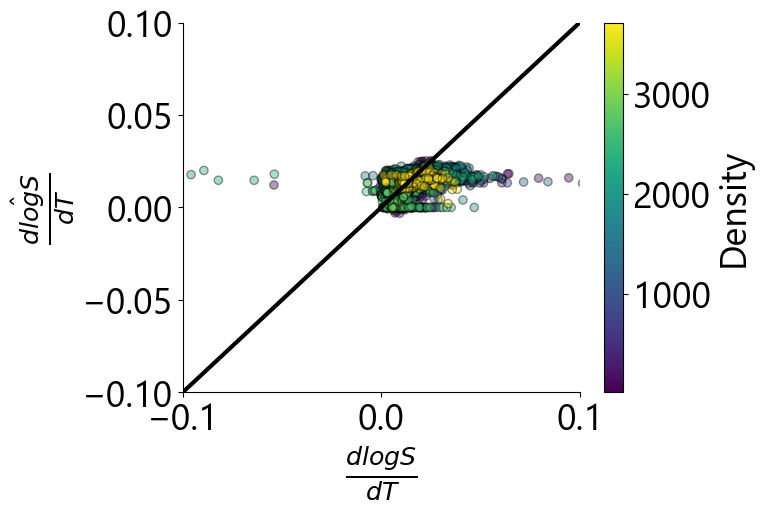

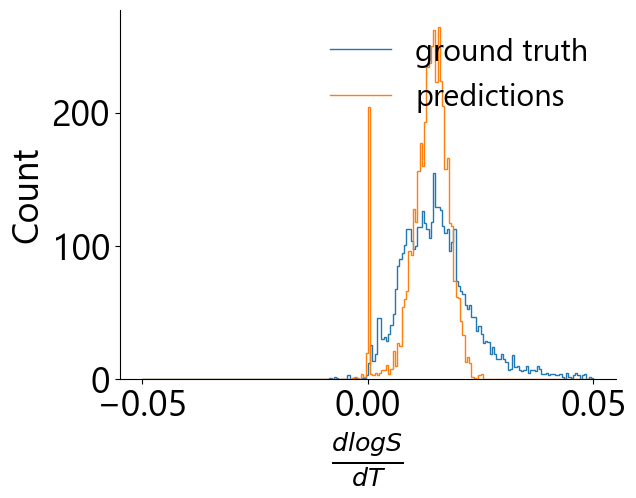

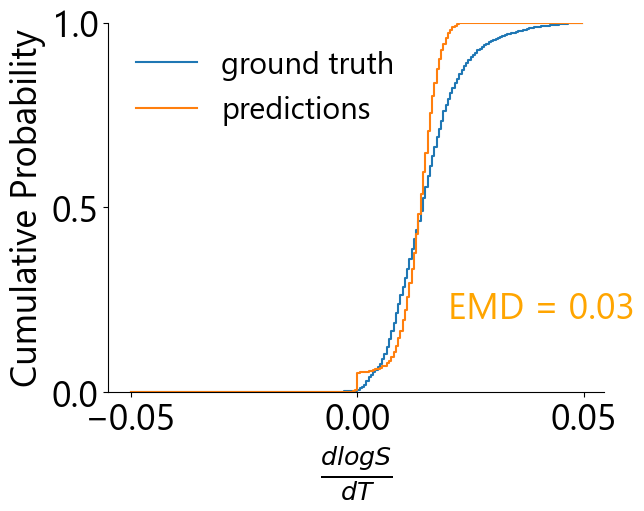

In [15]:
true_grads, pred_grads, mse, mae = gradient_analysis(fastprop_solprop_predictions)
gradient_parity_plot(true_grads, pred_grads)
ax1, true_grads_binned, pred_grads_binned, true_grad_bins_pdf, pred_grad_bins_pdf = pdf_plot(true_grads, pred_grads, bins =200)
ax2, true_grads_cdf, pred_grads_cdf, distance, true_grad_bins_cdf, pred_grad_bins_cdf = cdf_plot(true_grads, pred_grads, bins = 200)

chemprop predictions on SolProp dataset

In [284]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "chemprop_5215_predictions")
chemprop_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_chemprop_nonaq_predictions.csv"))

mse_chemprop_solprop, percentage_within_1_unit_chemprop_solprop = stats(chemprop_solprop_predictions['logS_true'], chemprop_solprop_predictions['logS_pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

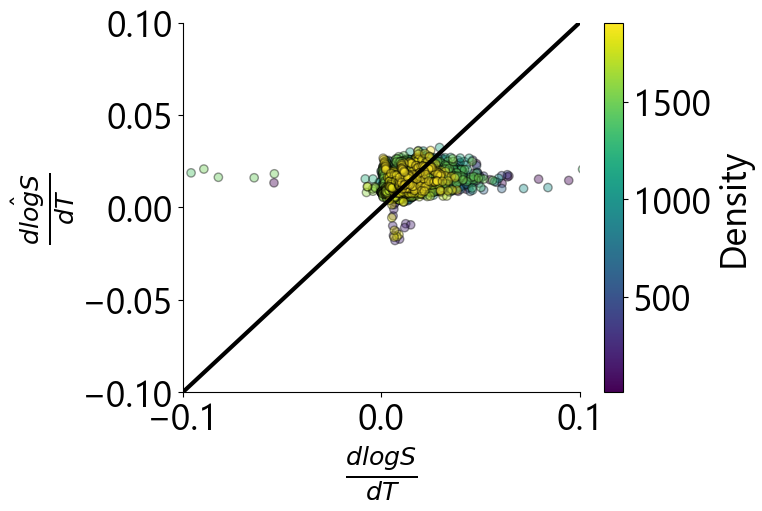

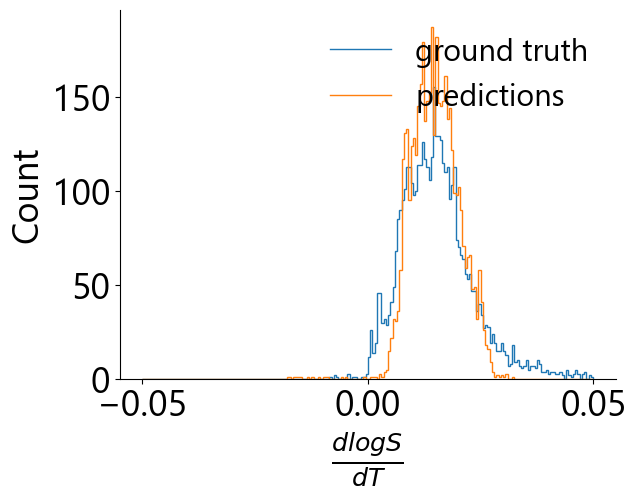

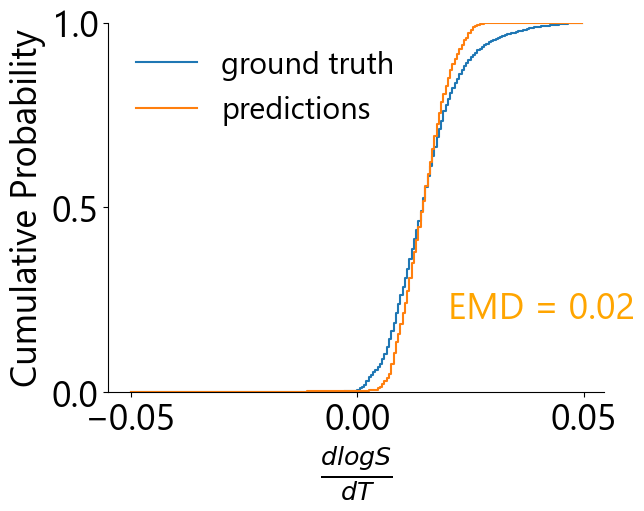

In [288]:
true_grads_chemprop, pred_grads_chemprop, mse_chemprop, mae_chemprop = gradient_analysis(chemprop_solprop_predictions)
gradient_parity_plot(true_grads_chemprop, pred_grads_chemprop)
ax1, true_grads_binned_chemprop, pred_grads_binned_chemprop, true_grad_bins_pdf_chemprop, pred_grad_bins_pdf_chemprop = pdf_plot(true_grads_chemprop, pred_grads_chemprop, bins =200)
ax2, true_grads_cdf_chemprop, pred_grads_cdf_chemprop, distance_chemprop, true_grad_bins_cdf_chemprop, pred_grad_bins_cdf_chemprop = cdf_plot(true_grads_chemprop, pred_grads_chemprop, bins = 200)

SolProp predictions on SolProp dataset

In [20]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "solprop_predictions")
vermiere_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_vermeire_predictions.csv"))
vermiere_solprop_predictions = vermiere_solprop_predictions.rename(columns = {"Solvent": "solvent_smiles","Solute": "solute_smiles", "Temp" : "temperature"})
solprop_solprop_predictions = fastprop_solprop_predictions.merge(vermiere_solprop_predictions[['solute_smiles', 'solvent_smiles', 'temperature', 'logST (method1) [log10(mol/L)]']], 
                on=['solute_smiles', 'solvent_smiles', 'temperature'], 
                how='left')
solprop_solprop_predictions.pop('logS_pred')
solprop_solprop_predictions.rename(columns = {'logST (method1) [log10(mol/L)]': 'logS_pred'}, inplace=True)

mse_solprop_solprop, percentage_within_1_unit_solprop_solprop = stats(solprop_solprop_predictions['logS_true'], solprop_solprop_predictions['logS_pred'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

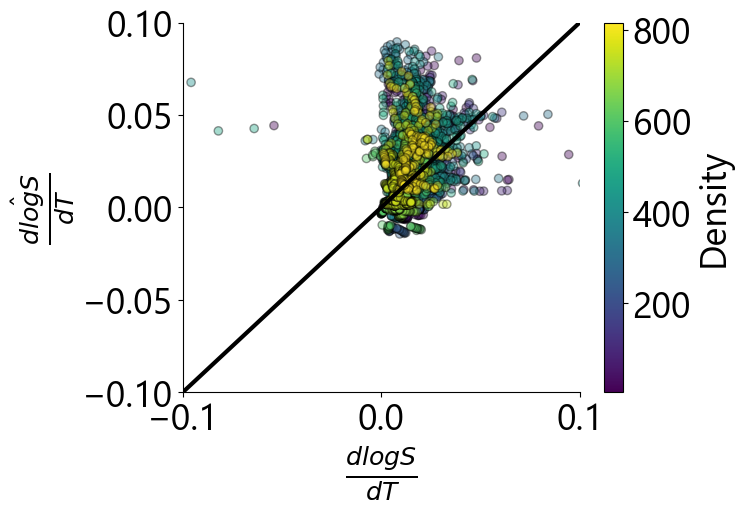

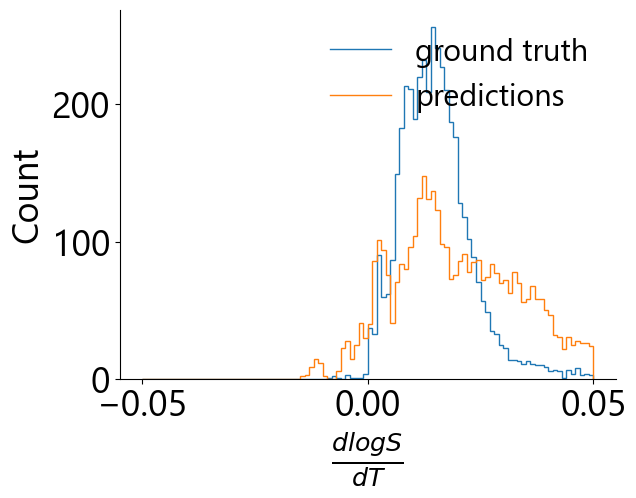

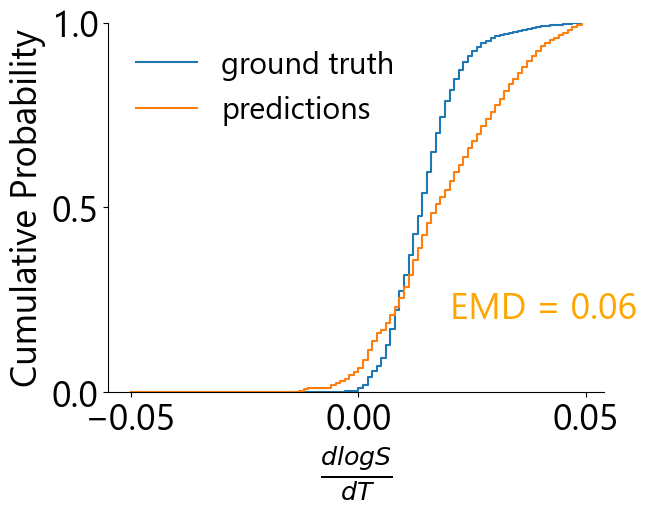

In [21]:
true_grads_solprop, pred_grads_solprop, mse_solprop, mae_solprop = gradient_analysis(solprop_solprop_predictions)
gradient_parity_plot(true_grads_solprop, pred_grads_solprop)
ax1, true_grads_binned_solprop, pred_grads_binned_solprop, true_grad_bins_pdf_solprop, pred_grad_bins_pdf_solprop = pdf_plot(true_grads_solprop, pred_grads_solprop, bins =100)
ax2, true_grads_cdf_solprop, pred_grads_cdf_solprop, distance_solprop, true_grad_bins_cdf_solprop, pred_grad_bins_cdf_solprop = cdf_plot(true_grads_solprop, pred_grads_solprop, bins = 100)

Residual Error

In [23]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
solprop_features: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq.csv"))

In [30]:
merged_fastprop = solprop_features.merge(fastprop_solprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')
merged_chemprop = solprop_features.merge(chemprop_solprop_predictions, on=['solute_smiles', 'solvent_smiles', 'temperature'], how='left')

# Calculate residuals for each model
merged_fastprop['squared_residual'] = (merged_fastprop['logS_true'] - merged_fastprop['logS_pred'])**2
merged_chemprop['squared_residual'] = (merged_chemprop['logS_true'] - merged_chemprop['logS_pred'])**2

In [31]:
def residual_cumsum(merged_fastprop, merged_chemprop, feature):
    
    #sort
    merged_fastprop_sorted_weight = merged_fastprop.sort_values(by=feature)
    merged_chemprop_sorted_weight = merged_chemprop.sort_values(by=feature)

    # Calculate cumulative residuals
    merged_fastprop_sorted_weight['cumulative_residual'] = merged_fastprop_sorted_weight['squared_residual'].cumsum()
    merged_chemprop_sorted_weight['cumulative_residual'] = merged_chemprop_sorted_weight['squared_residual'].cumsum()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(merged_fastprop_sorted_weight[feature], merged_fastprop_sorted_weight['cumulative_residual'], label='Fastprop', color='blue')
    plt.plot(merged_chemprop_sorted_weight[feature], merged_chemprop_sorted_weight['cumulative_residual'], label='Chemprop', color='red')
    plt.title('Cumulative Residuals vs ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Cumulative Residual')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

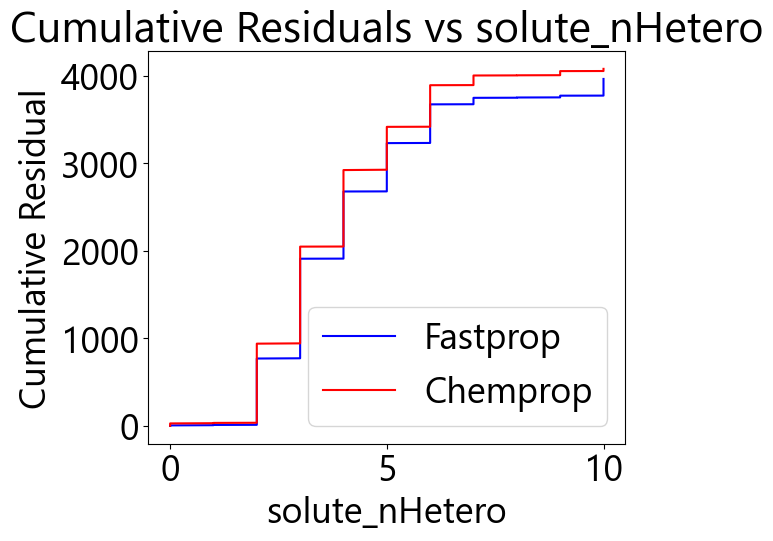

In [32]:
residual_cumsum(merged_fastprop, merged_chemprop, 'solute_nHetero')

In [34]:
def avg_leeds(acetone, benzene, ethanol):
    # weight average of the three Leeds sets based on dataset size
    return (acetone * 324 + benzene * 397 + ethanol * 573) / (324 + 397 + 573)

## Mean-guessing Baseline

In [35]:
baseline_leeds_results_replicate_1 = [
    [1.0320014081273676, 1.0875248176306136, 1.1091777679417225],
    [1.0325258376586919, 1.0872600591835906, 1.1080953499322557],
    [1.0308492419162676, 1.08816756822006, 1.111677189423604],
    [1.02976675966675, 1.0888579361048114, 1.1141973522394397],
    [1.021339399908061, 1.1010218023082272, 1.1473382826518777],
    [1.0221185369543442, 1.0986609017501938, 1.141809300954433],
    [1.0225019277406213, 1.0977239087490607, 1.1395370151783468],
    [1.0220899620699544, 1.09873550081136, 1.1419881602473827],
    [1.0222431378250945, 1.0983438074719059, 1.1410457325647723],
]
baseline_solprop_results_replicate_1 = [
    1.0596170222892463,
    1.0600764961470845,
    1.0586118474168256,
    1.0576735265309962,
    1.0508416197744765,
    1.0513873189637901,
    1.0516714444019486,
    1.0513664732849264,
    1.051478785662978,
]
baseline_leeds_results_replicate_1 = [avg_leeds(*l) for l in baseline_leeds_results_replicate_1]

baseline_leeds_results_replicate_2 = [
    [1.052422398030413, 1.0842809409393421, 1.0810465219075338],
    [1.0530486422663659, 1.0843236276176862, 1.0804654896196446],
    [1.064468383274447, 1.0859364067664783, 1.071521257598125],
    [1.0328480796606656, 1.0871053127936603, 1.1074460132232844],
    [1.0230000912599797, 1.096652726348915, 1.1368763081943298],
    [1.0245445481857451, 1.0940293523336977, 1.1300182016614662],
    [1.0212861487880267, 1.1012153350103637, 1.1477803695122848],
    [1.0208575132856128, 1.1030212994054933, 1.1518341570312916],
    [1.0211629430491502, 1.1016853332714294, 1.148847573089719],
]
baseline_solprop_results_replicate_2 = [
    1.0780078824185026,
    1.0785820047588262,
    1.0891117763804756,
    1.0603593826020425,
    1.0520507888725492,
    1.053275357924502,
    1.0508065563047457,
    1.0505415374561158,
    1.0507269731853042,
]
baseline_leeds_results_replicate_2 = [avg_leeds(*l) for l in baseline_leeds_results_replicate_2]

baseline_leeds_results_replicate_3 = [
    [1.0215166973430607, 1.1235512304471333, 1.1921542511221856],
    [1.0217991646268632, 1.1249198031819254, 1.194595666675122],
    [1.0239560724975518, 1.1333071672586001, 1.2091233289934629],
    [1.0201727942507235, 1.1128534359527684, 1.1721816483048668],
    [1.0233218227930796, 1.0960304872408182, 1.1352966556576847],
    [1.0214832399933074, 1.1005243674424996, 1.1461946802387821],
    [1.0206116043329145, 1.1043663903924588, 1.1547766387412624],
    [1.0215336704417277, 1.1003579128415355, 1.1458095898675373],
    [1.022129004370582, 1.0986337554292627, 1.1417441420503431],
]
baseline_solprop_results_replicate_3 = [
    1.052564988307435,
    1.0529169783353587,
    1.0554616734762352,
    1.050599969987862,
    1.052300616683013,
    1.0509380897379963,
    1.0504109322604087,
    1.0509724636700106,
    1.0513949675839962,
]
baseline_leeds_results_replicate_3 = [avg_leeds(*l) for l in baseline_leeds_results_replicate_3]

## Replicate 1

In [36]:
# fastprop-sobolev
fastprop_sobolev_solprop_results_replicate_1 = [
    1.0894436355257175,
    1.1721442132408688,
    1.0538208741900625,
    0.9496760013592687,
    0.9101050529427456,
    0.8612530334771499,
    0.8493672435150511,
    0.8206498066598069,
    0.8328533589756244,
]
fastprop_sobolev_leeds_results_replicate_1 = [
    [1.098086998274878, 1.0831588153410066, 1.000226309321898],
    [1.0933644479748381, 1.1135018525731564, 1.1959273540861242],
    [1.0588475452115977, 1.1067116846734186, 1.104706888814891],
    [0.9349734427543177, 1.121364118212081, 1.263639219792161],
    [0.825132921531389, 1.2484484596897076, 1.0482427090523379],
    [1.0321969058209788, 1.2057028634683329, 1.0318606682209734],
    [0.8578904310454997, 0.9761579273014561, 1.0291637648604577],
    [0.8927274052050455, 0.99315855296711, 0.9973063970262499],
    [0.8626893212359744, 0.9686162822954524, 0.9891065764318182],
]
fastprop_sobolev_leeds_results_replicate_1 = [avg_leeds(*l) for l in fastprop_sobolev_leeds_results_replicate_1]
# chemprop-sobolev
chemprop_sobolev_solprop_results_replicate_1 = [
    1.1497952565825045,
    1.0610892262698401,
    1.0555695600980208,
    0.9374059529391622,
    0.8831357715289297,
    0.8317885280848967,
    0.8224489219005123,
    0.8492062318078925,
    0.8306845218144837,
]
chemprop_sobolev_leeds_results_replicate_1 = [
    [1.1758190063792793, 1.0677919484098555, 1.0455104638627213],
    [1.0616109589273472, 1.086435521670648, 1.1309164613507312],
    [1.0618566445211848, 1.0926023306937676, 1.0485130420264637],
    [0.93367056236705, 1.1824316745577537, 1.2347912510551324],
    [0.8534371233233713, 1.1636187169234722, 1.120517972566954],
    [0.947122484604459, 1.132224499491962, 1.0214675389763208],
    [0.8733751637142293, 1.1091703852100927, 1.1400552829009736],
    [0.8327461279572382, 1.0850306511995536, 1.0545368211279638],
    [0.8181557795150924, 1.0234250400881229, 1.0474381772041559],
]
chemprop_sobolev_leeds_results_replicate_1 = [avg_leeds(*l) for l in chemprop_sobolev_leeds_results_replicate_1]

## Replicate 2

In [37]:
fastprop_sobolev_solprop_results_replicate_2 = [
    1.0530312142392055,
    1.01082443776922,
    1.0604352741699203,
    1.056171392349218,
    0.8838042929417375,
    0.8696819698320853,
    0.8263247385013266,
    0.8137702015159498,
    0.829800696975973,
]
fastprop_sobolev_leeds_results_replicate_2 = [
    [1.085687409051615, 1.0636411676026372, 1.0678980626063548],
    [0.9476257526131346, 1.1851077791567282, 1.0255855590307759],
    [1.1549872998006494, 1.107313039641634, 1.0242152715325532],
    [1.2250952651112454, 1.1985834949035263, 1.0317518597542947],
    [0.8459161637467256, 1.0548880421668188, 0.9910356989046806],
    [1.0189643692170085, 1.0691211427703733, 1.0185920870063536],
    [0.9509314040069956, 1.0156656771062087, 1.0221064792619077],
    [0.8548666252987315, 0.9626886334954792, 1.015161101069122],
    [0.8910725199883144, 0.9587493247998533, 1.0447551559335],
]
fastprop_sobolev_leeds_results_replicate_2 = [avg_leeds(*l) for l in fastprop_sobolev_leeds_results_replicate_2]
chemprop_sobolev_solprop_results_replicate_2 = [
    1.097217560426087,
    1.0027572632525492,
    0.974258844934736,
    0.942819322026133,
    0.8180057143683156,
    0.8585457222845644,
    0.8587530424030824,
    0.8351084920718321,
    0.8584380850342703,
]
chemprop_sobolev_leeds_results_replicate_2 = [
    [1.0948089576398645, 1.077160170903479, 1.045944752477498],
    [0.9868853446127274, 1.141529806875666, 1.20830475262909],
    [0.9657469213687935, 1.0704294403163352, 1.0492885576991346],
    [0.9825528047328009, 1.0375153400990733, 0.9874875500589523],
    [0.8873905789101989, 1.2196964707687488, 1.1730644397528451],
    [0.8914024685518382, 1.2216040906015468, 1.1472590780801453],
    [0.8736265845603066, 1.1441671532568576, 1.0690269169248159],
    [0.844797981584856, 1.0255509599186377, 1.010303946468873],
    [0.8397956559092257, 1.0187280808409849, 1.069262249982172],
]
chemprop_sobolev_leeds_results_replicate_2 = [avg_leeds(*l) for l in chemprop_sobolev_leeds_results_replicate_2]

## Replicate 3

In [38]:
fastprop_sobolev_solprop_results_replicate_3 = [
    1.0735340463533358,
    1.0748311478358001,
    1.0005034004413407,
    1.0015664696436568,
    0.9373605942603657,
    0.8792684981171591,
    0.8522644201935042,
    0.8327109661841252,
    0.8314312929420118,
]
fastprop_sobolev_leeds_results_replicate_3 = [
    [1.0997668004928243, 1.1509695437844811, 1.0773525566319218],
    [1.0310579134991291, 1.1174735053890554, 1.1733326824641266],
    [0.9885269522900566, 1.2216113430153293, 1.131348827163996],
    [1.6732090777177318, 1.258854927727087, 1.0944202313065068],
    [1.0955278415997785, 1.0006046134422104, 1.0785887128891136],
    [0.9530448266136291, 0.9926829361254309, 1.1106648019774872],
    [0.8644083682827283, 1.004185154087811, 1.0850326519747846],
    [0.8534027812395503, 0.9583454248238386, 1.0429539736295064],
    [0.8530558009887815, 0.9777246405907664, 1.0544064910957893],
]
fastprop_sobolev_leeds_results_replicate_3 = [avg_leeds(*l) for l in fastprop_sobolev_leeds_results_replicate_3]
chemprop_sobolev_solprop_results_replicate_3 = [
    1.0432325749568507,
    1.0154006949148053,
    0.9487669818636513,
    0.9817818163851326,
    0.9013256254989784,
    0.892905237528099,
    0.8461729991998993,
    0.8096142296422029,
    0.8490784299941238,
]
chemprop_sobolev_leeds_results_replicate_3 = [
    [1.0146586359977483, 1.0865769341874074, 1.1269892770592103],
    [1.024397294822305, 1.1751097975592188, 1.124628703213362],
    [0.9602975242743451, 1.2405920524636158, 1.1533060193313955],
    [0.9964318042149054, 1.2029450025157578, 1.08050080122522],
    [1.021758501189939, 1.1387094584511106, 1.1744960252898953],
    [0.9219943510549928, 1.0952324992343274, 1.1841192113492767],
    [0.8657208570376359, 1.0233809403496643, 1.0788230710135829],
    [0.8397682880017594, 1.0064802116554226, 1.0910553235957072],
    [0.7815839660728953, 0.9857042623579297, 0.990922539361896],
]
chemprop_sobolev_leeds_results_replicate_3 = [avg_leeds(*l) for l in chemprop_sobolev_leeds_results_replicate_3]

In [39]:
# average across the replicates
baseline_solprop_results = np.mean(
    [
        baseline_solprop_results_replicate_1,
        baseline_solprop_results_replicate_2,
        baseline_solprop_results_replicate_3,
    ],
    axis=0,
)
baseline_solprop_results_stdev = np.std(
    [
        baseline_solprop_results_replicate_1,
        baseline_solprop_results_replicate_2,
        baseline_solprop_results_replicate_3,
    ],
    axis=0,
)
baseline_leeds_results = np.mean(
    [
        baseline_leeds_results_replicate_1,
        baseline_leeds_results_replicate_2,
        baseline_leeds_results_replicate_3,
    ],
    axis=0,
)
baseline_leeds_results_stdev = np.std(
    [
        baseline_leeds_results_replicate_1,
        baseline_leeds_results_replicate_2,
        baseline_leeds_results_replicate_3,
    ],
    axis=0,
)
chemprop_sobolev_solprop_results = np.mean(
    [
        chemprop_sobolev_solprop_results_replicate_1,
        chemprop_sobolev_solprop_results_replicate_2,
        chemprop_sobolev_solprop_results_replicate_3,
    ],
    axis=0,
)
chemprop_sobolev_solprop_results_stdev = np.std(
    [
        chemprop_sobolev_solprop_results_replicate_1,
        chemprop_sobolev_solprop_results_replicate_2,
        chemprop_sobolev_solprop_results_replicate_3,
    ],
    axis=0,
)
chemprop_sobolev_leeds_results = np.mean(
    [
        chemprop_sobolev_leeds_results_replicate_1,
        chemprop_sobolev_leeds_results_replicate_2,
        chemprop_sobolev_leeds_results_replicate_3,
    ],
    axis=0,
)
chemprop_sobolev_leeds_results_stdev = np.std(
    [
        chemprop_sobolev_leeds_results_replicate_1,
        chemprop_sobolev_leeds_results_replicate_2,
        chemprop_sobolev_leeds_results_replicate_3,
    ],
    axis=0,
)
fastprop_sobolev_solprop_results = np.mean(
    [
        fastprop_sobolev_solprop_results_replicate_1,
        fastprop_sobolev_solprop_results_replicate_2,
        fastprop_sobolev_solprop_results_replicate_3,
    ],
    axis=0,
)
fastprop_sobolev_solprop_results_stdev = np.std(
    [
        fastprop_sobolev_solprop_results_replicate_1,
        fastprop_sobolev_solprop_results_replicate_2,
        fastprop_sobolev_solprop_results_replicate_3,
    ],
    axis=0,
)
fastprop_sobolev_leeds_results = np.mean(
    [
        fastprop_sobolev_leeds_results_replicate_1,
        fastprop_sobolev_leeds_results_replicate_2,
        fastprop_sobolev_leeds_results_replicate_3,
    ],
    axis=0,
)
fastprop_sobolev_leeds_results_stdev = np.std(
    [
        fastprop_sobolev_leeds_results_replicate_1,
        fastprop_sobolev_leeds_results_replicate_2,
        fastprop_sobolev_leeds_results_replicate_3,
    ],
    axis=0,
)
# other lines for the plot
training_size = [
    20,
    50,
    100,
    200,
    500,
    1000,
    2000,
    3500,
    5215,
]
lower_experimental_limit = [0.7] * len(training_size)
upper_experimental_limit = [1.0] * len(training_size)
vermeire_leeds = [avg_leeds(2.1720, 1.9709, 2.1013)] * len(training_size)
vermeire_solprop = [1.4775] * len(training_size)

<Figure size 640x480 with 0 Axes>

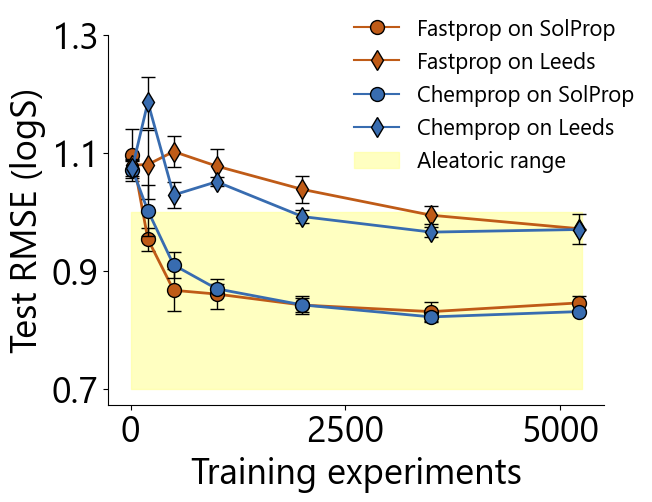

In [197]:
plt.figure(figsize=[6.4,4.8])
fig, ax1 = plt.subplots()

# hypothesized limit lines
# ax1.plot(np.hstack((training_size[0:-1], 5250)), lower_experimental_limit, label="_Lower Exptl. Limit", linestyle=":", color="#7f7f80")
# ax1.plot(np.hstack((training_size[0:-1], 5250)), upper_experimental_limit, label="_Upper Exptl. Limit", linestyle=":", color="#7f7f80")



ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    chemprop_sobolev_solprop_results[np.r_[0,3:9]] ,
    linestyle="none",
    linewidth = 1,
    color='black',
    marker="o",
    markersize=10,
    yerr=chemprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] , 
    markeredgecolor = 'black',
    capsize = 5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , chemprop_sobolev_solprop_results[np.r_[0, 3:9]] , markersize = 10, markeredgecolor = 'black', color=colors[6], marker="o", linestyle="-", linewidth = 2)

ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    chemprop_sobolev_leeds_results[np.r_[0, 3:9]] ,
    linestyle="-",
    linewidth = 1,
    color='black',
    marker="d",
    markersize=10,
    yerr=chemprop_sobolev_leeds_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
   fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , chemprop_sobolev_leeds_results[np.r_[0, 3:9]], markersize = 10, markeredgecolor = 'black', color=colors[6], marker="d", linestyle="-", linewidth = 2)

ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    fastprop_sobolev_solprop_results[np.r_[0, 3:9]],
    linestyle="-",
    linewidth = 1,
    color='black',
    marker='o',
    markersize=10,
    yerr=fastprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , fastprop_sobolev_solprop_results[np.r_[0, 3:9]] , markersize = 10, markeredgecolor = 'black', color=colors[4], marker="o", linestyle="-", linewidth = 2)
ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    fastprop_sobolev_leeds_results[np.r_[0, 3:9]],
    linestyle="-",
    linewidth = 1,
    color='black',
    marker="d",
    markersize=10,
    yerr=fastprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]]  , fastprop_sobolev_leeds_results[np.r_[0, 3:9]] , markersize = 10, markeredgecolor = 'black', color=colors[4], marker="d", linestyle="-", linewidth = 2)
ax1.plot([], [], label="Fastprop on SolProp", color=colors[6], markersize = 10, markeredgecolor = 'black', marker="o", linestyle="-")
ax1.plot([], [], label="Fastprop on Leeds", color=colors[6], markersize = 10, markeredgecolor = 'black', marker="d", linestyle="-")
ax1.plot([], [], label="Chemprop on SolProp", color=colors[4], markersize = 10, markeredgecolor = 'black', marker="o", linestyle="-")
ax1.plot([], [], label="Chemprop on Leeds", color=colors[4],markersize = 10, markeredgecolor = 'black',  marker="d", linestyle="-")
ax1.fill_between([0, 5250], 0.7, 1.0, label="Aleatoric range", color=colors[3],alpha = 0.6)
ax1.set_xlabel("Training experiments")
ax1.set_yticks([0.7, 0.9, 1.1, 1.3])
ax1.set_ylabel("Test RMSE (logS)")
ax1.set_xticks([0, 2500, 5000])
ax1.spines[['right', 'top']].set_visible(False)

#ax1.title("Approaching Aleatoric Limit")
ax1.legend(prop={'size': 16}, loc="upper right", bbox_to_anchor=(1.1, 1.1), frameon = False)
#ax1.text(10, 0.72, "Lower aleatoric limit", fontsize = 16)

plt.show()
# show vermeire?
# TODO: ADD A LINE TO THE PLOT WHICH SHOWS THE RESULT OF JUST PREDICTING THE MEAN (ACROSS ALL TRAINING DATA)
# COSMO can do this

Combined plot

Figure 3

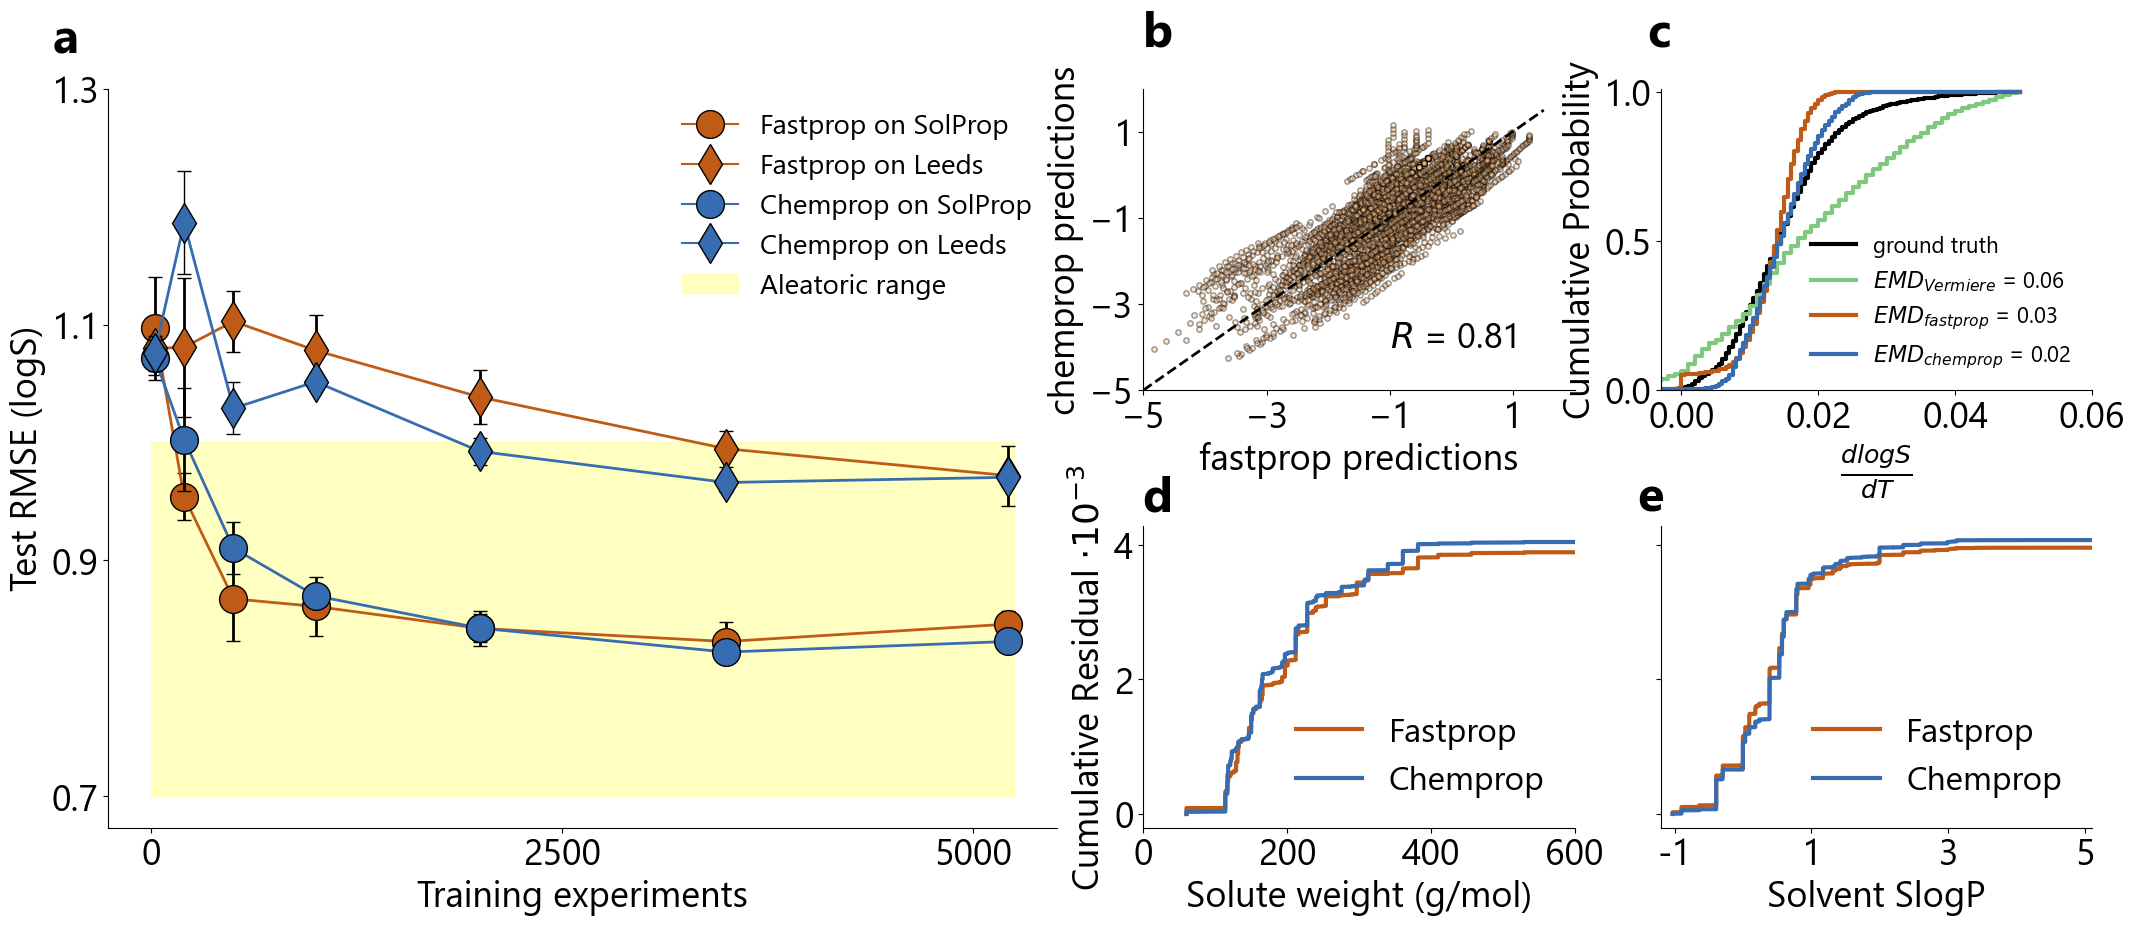

In [365]:

plt.figure(figsize=[6.4*4,4.8*2])

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2, rowspan = 2)

# hypothesized limit lines
# ax1.plot(np.hstack((training_size[0:-1], 5250)), lower_experimental_limit, label="_Lower Exptl. Limit", linestyle=":", color="#7f7f80")
# ax1.plot(np.hstack((training_size[0:-1], 5250)), upper_experimental_limit, label="_Upper Exptl. Limit", linestyle=":", color="#7f7f80")

ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    chemprop_sobolev_solprop_results[np.r_[0,3:9]] ,
    linestyle="none",
    linewidth = 2,
    color='black',
    marker="o",
    markersize=20,
    yerr=chemprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] , 
    markeredgecolor = 'black',
    capsize = 5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , chemprop_sobolev_solprop_results[np.r_[0, 3:9]] , markersize = 20, markeredgecolor = 'black', color=colors[6], marker="o", linestyle="-", linewidth = 2)

ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    chemprop_sobolev_leeds_results[np.r_[0, 3:9]] ,
    linestyle="-",
    linewidth = 2,
    color='black',
    marker="d",
    markersize=20,
    yerr=chemprop_sobolev_leeds_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
   fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , chemprop_sobolev_leeds_results[np.r_[0, 3:9]], markersize = 20, markeredgecolor = 'black', color=colors[6], marker="d", linestyle="-", linewidth = 2)

ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    fastprop_sobolev_solprop_results[np.r_[0, 3:9]],
    linestyle="-",
    linewidth = 2,
    color='black',
    marker='o',
    markersize=20,
    yerr=fastprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]] , fastprop_sobolev_solprop_results[np.r_[0, 3:9]] , markersize = 20, markeredgecolor = 'black', color=colors[4], marker="o", linestyle="-", linewidth = 2)
ax1.errorbar(
    np.array(training_size)[np.r_[0, 3:9]] ,
    fastprop_sobolev_leeds_results[np.r_[0, 3:9]],
    linestyle="-",
    linewidth = 1,
    color='black',
    marker="d",
    markersize=20,
    yerr=fastprop_sobolev_solprop_results_stdev[np.r_[0, 3:9]] ,
    markeredgecolor = 'black',
    capsize=5, 
    fmt='none'
)
ax1.plot(np.array(training_size)[np.r_[0, 3:9]]  , fastprop_sobolev_leeds_results[np.r_[0, 3:9]] , markersize = 20, markeredgecolor = 'black', color=colors[4], marker="d", linestyle="-", linewidth = 2)
ax1.plot([], [], label="Fastprop on SolProp", color=colors[6], markersize = 20, markeredgecolor = 'black', marker="o", linestyle="-")
ax1.plot([], [], label="Fastprop on Leeds", color=colors[6], markersize = 20, markeredgecolor = 'black', marker="d", linestyle="-")
ax1.plot([], [], label="Chemprop on SolProp", color=colors[4], markersize = 20, markeredgecolor = 'black', marker="o", linestyle="-")
ax1.plot([], [], label="Chemprop on Leeds", color=colors[4],markersize = 20, markeredgecolor = 'black',  marker="d", linestyle="-")
ax1.fill_between([0, 5250], 0.7, 1.0, label="Aleatoric range", color=colors[3],alpha = 0.6)
ax1.set_xlabel("Training experiments")
ax1.set_yticks([0.7, 0.9, 1.1, 1.3])
ax1.set_ylabel("Test RMSE (logS)")
ax1.set_xticks([0, 2500, 5000])
ax1.spines[['right', 'top']].set_visible(False)

#ax1.title("Approaching Aleatoric Limit")
ax1.legend(prop={'size': 20}, loc="upper right", frameon = False)
ax1.text(-600, 1.33, "a", weight = 'bold', fontsize = 35)

plt.subplots_adjust(hspace=0.45)


ax2 = plt.subplot2grid(shape=(2,4), loc=(0,2), colspan=1, rowspan = 1)

r = pearsonr(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'])
ax2.text(-5, 3, "b", weight='bold', fontsize = 35)
ax2.text(-1, -4, r'$R$' + f" = {r[0]:.2f}", fontsize = 25)
ax2.plot([-5, 1.5], [-5,1.5], linestyle = '--', linewidth = 2, color = 'black')

ax2.scatter(merged_fastprop['logS_pred'], merged_chemprop['logS_pred'], color=colors[2], s = 15, edgecolors ='black', alpha = 0.4)
ax2.set_xlabel('fastprop predictions')
ax2.set_ylabel('chemprop predictions')
ax2.set_ylim([-5, 2])
ax2.set_xlim([-5, 2])

ax2.set_yticks([-5, -3, -1, 1])

ax2.set_xticks([-5, -3, -1, 1])
ax2.spines[['right', 'top']].set_visible(False)

# Plot the CDFs as step plots
# ax2.step(true_grad_bins_cdf[:-1], true_grads_cdf, linewidth = 3, where='post', color = 'black', label='ground truth')

# ax2.text(-0.06, 1.15, "b", weight='bold', fontsize = 35)
# # Set axis limits
# ax2.set_ylim([0, 1.01])
# ax2.set_yticks([0,0.5 ,1])

# ax2.set_ylabel("Cumulative Probability")
# ax2.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax2.legend(prop={'size': 20}, loc='upper left', frameon=False)
# ax2.spines[['right', 'top']].set_visible(False)
# #ax1.set_title("Solprop", fontsize = 25)



ax3 = plt.subplot2grid(shape=(2,4), loc=(0,3), colspan=1, rowspan = 1)
ax3.step(true_grad_bins_cdf[:-1], true_grads_cdf, linewidth = 3, where='post', color = 'black', label='ground truth')
ax3.step(pred_grad_bins_cdf_solprop[:-1], pred_grads_cdf_solprop, linewidth = 3,color = colors[0], where='post', label=r'$EMD_{Vermiere}}$' + f" = {distance_solprop:.2f}")
ax3.step(pred_grad_bins_cdf[:-1], pred_grads_cdf, where='post', linewidth = 3,color = colors[6], label= r'$EMD_{fastprop}$' + f" = {distance:.2f}")
ax3.step(pred_grad_bins_cdf[:-1], pred_grads_cdf_chemprop, where='post', linewidth = 3,color = colors[4], label=r'$EMD_{chemprop}$' + f" = {distance_chemprop:.2f}")

# ax3.text(0.02, 0.3, r'$EMD_{Vermiere}}$' + f" = {distance_solprop:.2f}", fontsize = 18)
# ax3.text(0.02, 0.2, r'$EMD_{fastprop}$' + f" = {distance:.2f}", fontsize = 18)
# ax3.text(0.02, 0.1, r'$EMD_{chemprop}$' + f" = {distance_chemprop:.2f}", fontsize = 18)

# Set axis limits
ax3.set_ylim([0, 1.01])
ax3.set_yticks([0,0.5 ,1])
ax3.text(-0.005, 1.15, "c", weight = 'bold', fontsize = 35)
ax3.set_xlim([-0.003, 0.06])
ax3.set_xticks([0,0.02, 0.04, 0.06])

ax3.set_ylabel("Cumulative Probability")
ax3.set_xlabel(r"$\frac{dlogS}{dT}$")
ax3.legend(prop={'size': 16}, loc='lower right', frameon=False)
ax3.spines[['right', 'top']].set_visible(False)
#ax2.set_title("Fastsolv", fontsize = 25)



ax4= plt.subplot2grid(shape=(2,4), loc=(1,2), colspan=1, rowspan = 1)
feature = 'solute_MW'
merged_fastprop_sorted_weight = merged_fastprop.sort_values(by=feature)
merged_chemprop_sorted_weight = merged_chemprop.sort_values(by=feature)

# Calculate cumulative residuals
merged_fastprop_sorted_weight['cumulative_residual'] = merged_fastprop_sorted_weight['squared_residual'].cumsum()
merged_chemprop_sorted_weight['cumulative_residual'] = merged_chemprop_sorted_weight['squared_residual'].cumsum()

ax4.plot(merged_fastprop_sorted_weight[feature], merged_fastprop_sorted_weight['cumulative_residual'].div(1000), label='Fastprop', color=colors[6], linewidth = 3)
ax4.plot(merged_chemprop_sorted_weight[feature], merged_chemprop_sorted_weight['cumulative_residual'].div(1000), label='Chemprop', color=colors[4], linewidth = 3)
#ax4.set_title('Cumulative Residuals vs ' + feature )
ax4.set_xlabel("Solute weight (g/mol)")
ax4.set_xlim([0, 600])
ax4.set_xticks([0, 200, 400, 600])
ax4.set_xticklabels([0, 200, 400,  600])
ax4.set_ylabel(r'Cumulative Residual $\cdot 10^{-3}$')
ax4.legend(prop={'size': 24}, loc='lower right', frameon=False)
ax4.spines[['right', 'top']].set_visible(False)
ax4.text(-0.8,4.5, "d", weight='bold', fontsize = 35)


ax5= plt.subplot2grid(shape=(2,4), loc=(1,3), colspan=1, rowspan = 1)
ax5 = plt.gca()

feature = 'solvent_SLogP'
merged_fastprop_sorted_weight = merged_fastprop.sort_values(by=feature)
merged_chemprop_sorted_weight = merged_chemprop.sort_values(by=feature)

# Calculate cumulative residuals
merged_fastprop_sorted_weight['cumulative_residual'] = merged_fastprop_sorted_weight['squared_residual'].cumsum()
merged_chemprop_sorted_weight['cumulative_residual'] = merged_chemprop_sorted_weight['squared_residual'].cumsum()

ax5.plot(merged_fastprop_sorted_weight[feature], merged_fastprop_sorted_weight['cumulative_residual'].div(1000), label='Fastprop', color=colors[6], linewidth = 3)
ax5.plot(merged_chemprop_sorted_weight[feature], merged_chemprop_sorted_weight['cumulative_residual'].div(1000), label='Chemprop', color=colors[4], linewidth = 3)
#ax4.set_title('Cumulative Residuals vs ' + feature )
ax5.set_xlabel("Solvent SlogP")
ax5.set_yticklabels([])
ax5.set_xlim([-1.2, 5.1])
ax5.set_xticks([-1, 1, 3,5])
ax5.set_xticklabels([-1, 1, 3, 5])

ax5.legend(prop={'size': 24}, loc='lower right', frameon=False)
ax5.spines[['right', 'top']].set_visible(False)
ax5.text(-1.55,4.5, "e", weight='bold', fontsize = 35)


plt.show()

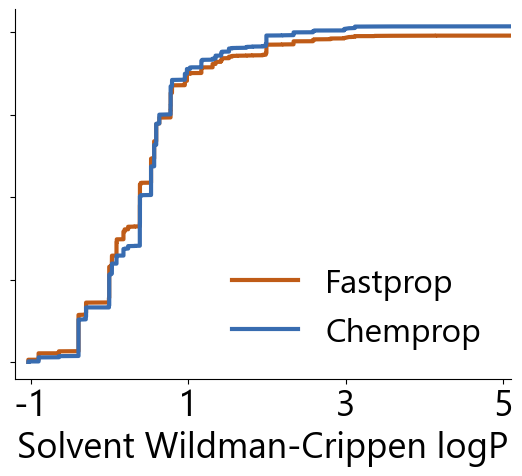

In [273]:
plt.figure(figsize=[6.4,4.8])
ax5 = plt.gca()

feature = 'solvent_SLogP'
merged_fastprop_sorted_weight = merged_fastprop.sort_values(by=feature)
merged_chemprop_sorted_weight = merged_chemprop.sort_values(by=feature)

# Calculate cumulative residuals
merged_fastprop_sorted_weight['cumulative_residual'] = merged_fastprop_sorted_weight['squared_residual'].cumsum()
merged_chemprop_sorted_weight['cumulative_residual'] = merged_chemprop_sorted_weight['squared_residual'].cumsum()

ax5.plot(merged_fastprop_sorted_weight[feature], merged_fastprop_sorted_weight['cumulative_residual'].div(1000), label='Fastprop', color=colors[6], linewidth = 3)
ax5.plot(merged_chemprop_sorted_weight[feature], merged_chemprop_sorted_weight['cumulative_residual'].div(1000), label='Chemprop', color=colors[4], linewidth = 3)
#ax4.set_title('Cumulative Residuals vs ' + feature )
ax5.set_xlabel("Solvent Wildman-Crippen logP")
ax5.set_yticklabels([])
ax5.set_xlim([-1.2, 5.1])
ax5.set_xticks([-1, 1, 3,5])
ax5.set_xticklabels([-1, 1, 3, 5])

ax5.legend(prop={'size': 24}, loc='lower right', frameon=False)
ax5.spines[['right', 'top']].set_visible(False)

plt.show()


In [ ]:
# plt.figure(figsize=[6.4*3,4.8])
# ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)


# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads_solprop, pred_grads_solprop, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads_solprop, pred_grads_solprop)])
# idx = z.argsort()
# x2, y2, z2 = true_grads_solprop[idx], pred_grads_solprop[idx], z[idx]


# ax1.scatter(true_grads_solprop,pred_grads_solprop, c = z2, alpha =0.4, edgecolors = 'black')
# ax1.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax1)
# cbar.ax.set_ylabel('Density')


# ax1.set_xlim([-0.1, 0.1])
# ax1.set_ylim([-0.1, 0.1])
# ax1.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax1.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax1.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax1.spines[['right', 'top']].set_visible(False)


# ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)

# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads, pred_grads, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads, pred_grads)])
# idx = z.argsort()
# x2, y2, z2 = true_grads[idx], pred_grads[idx], z[idx]


# ax2.scatter(true_grads,pred_grads, c = z2, alpha =0.4, edgecolors = 'black')
# ax2.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax2)
# cbar.ax.set_ylabel('Density')


# ax2.set_xlim([-0.1, 0.1])
# ax2.set_ylim([-0.1, 0.1])
# #ax2.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax2.set_yticklabels([])
# ax2.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax2.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax2.spines[['right', 'top']].set_visible(False)


# ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)

# bins = [100, 100] # number of bins
# hh, locx, locy = np.histogram2d(true_grads_custom, pred_grads_custom, bins=bins, density = True)

# # Sort the points by density, so that the densest points are plotted last
# z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(true_grads_custom, pred_grads_custom)])
# idx = z.argsort()
# x2, y2, z2 = true_grads[idx], pred_grads_custom[idx], z[idx]


# ax3.scatter(true_grads_custom,pred_grads_custom, c = z2, alpha =0.4, edgecolors = 'black')
# ax3.plot([-1, 1], [-1,1], linestyle = '-', linewidth = 3, color = 'black')

# norm = Normalize(vmin = np.min(z), vmax = np.max(z))
# cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax3)
# cbar.ax.set_ylabel('Density')


# ax3.set_xlim([-0.1, 0.1])
# ax3.set_ylim([-0.1, 0.1])
# #ax3.set_ylabel(r"$\frac{\hat{dlogS}}{dT}$")
# ax3.set_yticklabels([])
# ax3.set_xlabel(r"$\frac{dlogS}{dT}$")
# ax3.legend(prop={'size': 22}, loc = 'upper left', frameon = False) 
# ax3.spines[['right', 'top']].set_visible(False)

